# This notebook explores the data (TFRecord format) using a subsample of the YouTube-8M video & frame-level data. To work with the entire dataset, please refer to the Starter code on the [YouTube-8M github repo](https://github.com/google/youtube-8m).

In [ ]:
#### Installation notes ###
# To create environment: conda create -n myenv python=3.4 (for python 3.4)
# To activate anaconda environment: source activate envName
# To list all environments: conda info --envs

# Required packages:
# pip install sklearn
# pip install pandas
# pip install scipy
# pip install networkx
# pip install dict

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
training_data_dir = "../training_data/yt8m/v2"
print(os.listdir(training_data_dir))

# Any results you write to the current directory are saved as output.

['video', '.DS_Store', 'frame', 'models']


In [6]:
print(os.listdir(training_data_dir + "/frame"))
print(os.listdir(training_data_dir + "/video"))

['test0397.tfrecord', '2_frame_train_download_plan.json', 'train0434.tfrecord', 'train0274.tfrecord', 'validate0638.tfrecord', 'validate3489.tfrecord', 'validate2094.tfrecord', 'train0208.tfrecord', '2_frame_test_download_plan.json', 'train0580.tfrecord', '2_frame_validate_download_plan.json', 'validate1831.tfrecord', 'validate1704.tfrecord', 'test3134.tfrecord', 'test2108.tfrecord', 'test1553.tfrecord', 'train2161.tfrecord']
['2_video_train_download_plan.json', 'test0397.tfrecord', '2_video_test_download_plan.json', 'train0434.tfrecord', '2_video_validate_download_plan.json', 'train0274.tfrecord', 'validate0638.tfrecord', 'validate3489.tfrecord', 'validate2094.tfrecord', 'train0208.tfrecord', 'train0580.tfrecord', 'validate1831.tfrecord', 'validate1704.tfrecord', 'test3134.tfrecord', 'test2108.tfrecord', 'test1553.tfrecord', 'train2161.tfrecord']


In [10]:
#Loading libraries & datasets
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo
train_data_id = "0208"
video_lvl_record = training_data_dir + "/video/train" + train_data_id + ".tfrecord"
frame_lvl_record = training_data_dir + "/frame/train" + train_data_id + ".tfrecord"

# Let's start with the video-level data

In [11]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [12]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('Picking a youtube video id:',vid_ids[13])
print('First 20 features of a youtube video (',vid_ids[13],'):')
print(mean_rgb[13][:20])

Number of videos in this tfrecord:  1003
Picking a youtube video id: tedw
First 20 features of a youtube video ( tedw ):
[-1.3979190587997437, 1.3181191682815552, -0.6727305054664612, 0.6157562136650085, 0.4521563947200775, 0.4070080816745758, 0.07166368514299393, 0.06130671873688698, -0.18977423012256622, 0.13159328699111938, 0.09810913354158401, -0.32069429755210876, 0.18438364565372467, 0.3411458432674408, 0.8093208074569702, 0.08855659514665604, -0.13296176493167877, -0.7093318104743958, 0.5643736124038696, -0.08529961854219437]


As described on the [YouTube8M download page](https://research.google.com/youtube8m/video_id_conversion.html), for privacy reasons, the video `id` has been randomly generated and does not directly correspond to the actual YouTube video id. To convert the `id` into the actua YouTube video id, we follow link: [http://data.yt8m.org/2/j/i/1r/1r00.js](http://data.yt8m.org/2/j/i/1r/1r00.js)

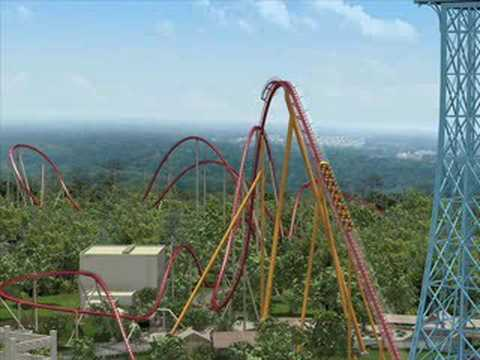

In [13]:
#With that video id, we can play the video
YouTubeVideo('-QM5ooctj0w')

# Now, let's read the frame-level data

In [14]:
# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

In [15]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 265 frames


# Now let's explore the labels

First, we'll find the most commonly used labels...

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

In [24]:
labels_2018 = pd.read_csv(training_data_dir + '/label_names_2018_fixed.csv')
print("we have {} unique labels in the dataset".format(len(labels_2018['label_name'].unique())))

we have 3807 unique labels in the dataset


In [25]:
n=10
from collections import Counter
label_mapping = pd.read_csv(training_data_dir + '/label_names_2018_fixed.csv',header=0,index_col=0,squeeze=True).T.to_dict()

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels]
top_n_label_names

['Game',
 'Video game',
 'Vehicle',
 'Concert',
 'Musician',
 'Cartoon',
 'Performance art',
 'Car',
 'Dance',
 'Guitar']

And plot the relationships between each of these top labels...

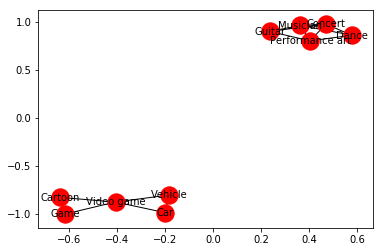

In [26]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G,font_size="10")

And a t-SNE plot on the data...

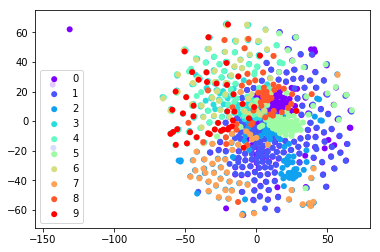

In [27]:
colors = plt.cm.rainbow(np.linspace(0, 1, n))
mean_rgb_top_n = []
labels_for_tsne = []
# filtering mean_rgb so it only contains top n labels
for idx, list_of_nodes in enumerate(labels):
    for node in list_of_nodes:
        if node in top_n_labels:
            mean_rgb_top_n.append(mean_rgb[idx])
            labels_for_tsne.append(node)


X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


fig = plt.figure()
ax = fig.add_subplot(111)

handles = []
for indx, color in enumerate(colors):
    this_label = top_n_labels[indx]
    X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
    handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

ax.legend(handles, top_n_labels)

plt.show()